In [1]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col

from pyspark.sql.functions import lit, current_timestamp, unix_timestamp

In [2]:
from IPython.display import Image, HTML, display
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("best_one").\
        getOrCreate()

In [3]:
from pyspark.ml.recommendation import ALS
from pyspark.sql.functions import col, lit


# появились конфиги - что это?

spark.conf.set("es.nodes","89.253.237.183")
spark.conf.set("es.port","9200")
spark.conf.set("es.nodes.wan.only","true")
spark.conf.set("es.index.auto.create", "true")


spark.conf.set('spark.jars.packages', 'elasticsearch-spark-20_2.11-7.12.0.jar')
#spark.conf.set('spark.jars.packages', 'elasticsearch-hadoop-7.12.0.jar')

In [5]:
spark.conf.get('spark.jars.packages')

'elasticsearch-spark-20_2.11-7.12.0.jar'

### Загрузка данных

In [7]:
ratings = spark.read.csv("data/ratings.csv", header=True, inferSchema=True)
ratings.cache()

print("Number of ratings: {}".format(ratings.count()))
print("Sample of ratings:")
ratings.show(5)

Number of ratings: 100836
Sample of ratings:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [8]:
# timestamp в Unix TimeStamp (добавим нули )

ratings = ratings.select(ratings.userId,
                         ratings.movieId,
                         ratings.rating,
                         (ratings.timestamp.cast("long") * 1000).alias("timestamp"))
ratings.show(5)

+------+-------+------+------------+
|userId|movieId|rating|   timestamp|
+------+-------+------+------------+
|     1|      1|   4.0|964982703000|
|     1|      3|   4.0|964981247000|
|     1|      6|   4.0|964982224000|
|     1|     47|   5.0|964983815000|
|     1|     50|   5.0|964982931000|
+------+-------+------+------------+
only showing top 5 rows



**Movies**


In [9]:
raw_movies = spark.read.csv("data/movies.csv", header=True, inferSchema=True)

print("Raw movie data:")
raw_movies.show(5, truncate=False)

Raw movie data:
+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [13]:
# udf для жанра (всё в нижний регистр)

extract_genres = udf(lambda x: x.lower().split("|"), ArrayType(StringType()))

raw_movies.select("movieId",
                  "title",
                  extract_genres("genres").alias("genres")).show(5, False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genres                                           |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji (1995)                    |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men (1995)           |[comedy, romance]                                |
|4      |Waiting to Exhale (1995)          |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II (1995)|[comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



In [12]:
# сделаем оделение года выпока от описания фильма
import re
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, 1970)
    except:
        print(title)

        
extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))
    
# проведем тестирования
s = "Jumanji (1995)"
extract_year_fn(s)

('Jumanji', '1995')

In [14]:
# применим функцию
movies = raw_movies.select("movieId", extract_year("title").title.alias("title"),\
                           extract_year("title").release_date.alias("release_date"),\
                           extract_genres("genres").alias("genres"))

print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------------+
|movieId|title                      |release_date|genres                                           |
+-------+---------------------------+------------+-------------------------------------------------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |
+-------+---------------------------+------------+-------------------------------------------------+
only showing top 5 rows



In [9]:
link_data = spark.read.csv("data/links.csv", header=True, inferSchema=True)


# добавим tmdbId
movie_data = movies.join(link_data, movies.movieId == link_data.movieId)\
                   .select(movies.movieId,
                           movies.title,
                           movies.release_date,
                           movies.genres,
                           link_data.tmdbId)

num_movies = movie_data.count()

print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------------+------+
|movieId|title                      |release_date|genres                                           |tmdbId|
+-------+---------------------------+------------+-------------------------------------------------+------+
|1      |Toy Story                  |1995        |[adventure, animation, children, comedy, fantasy]|862   |
|2      |Jumanji                    |1995        |[adventure, children, fantasy]                   |8844  |
|3      |Grumpier Old Men           |1995        |[comedy, romance]                                |15602 |
|4      |Waiting to Exhale          |1995        |[comedy, drama, romance]                         |31357 |
|5      |Father of the Bride Part II|1995        |[comedy]                                         |11862 |
+-------+---------------------------+------------+------------------------------------------------

Successfully imported tmdbsimple!


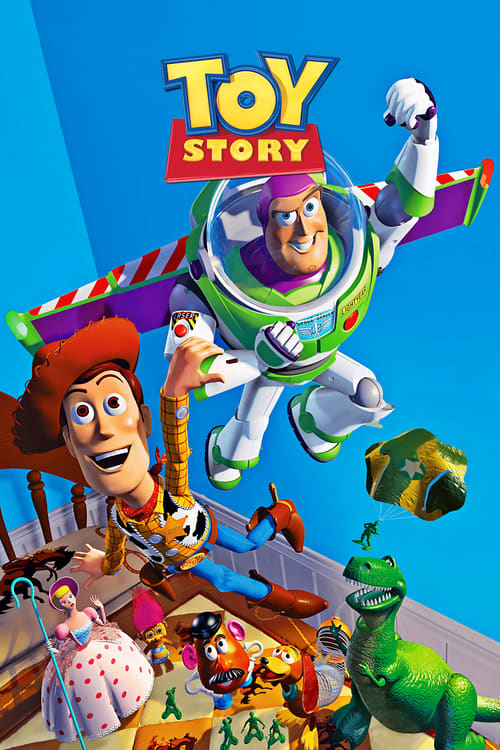

In [10]:
# пример получения картинки с сервиса https://www.themoviedb.org/
try:
    import tmdbsimple as tmdb
    import json
    from requests.exceptions import HTTPError
    # получите свой ключ
    tmdb.API_KEY = '3403d7129a0d23281bf49971d87b43e0'
    print("Successfully imported tmdbsimple!")
    
    # пример URL
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
    
except ImportError:
    print("Cannot import tmdbsimple as it is not installed, no movie posters will be displayed!")
    
except HTTPError as e:
    if e.response.status_code == 401:
        j = json.loads(e.response.text)
        print("TMdb API call failed: {}".format(j['status_message']))

In [15]:
from elasticsearch import Elasticsearch

# запускаем ElasticSearch
es = Elasticsearch(hosts='89.253.237.183:9200')
es.info(pretty=True)

{'name': 'vps-11009347-124249.host4g.ru',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'tZ8R80WeRm6V4yiMpzZP2A',
 'version': {'number': '7.12.0',
  'build_flavor': 'default',
  'build_type': 'tar',
  'build_hash': '78722783c38caa25a70982b5b042074cde5d3b3a',
  'build_date': '2021-03-18T06:17:15.410153305Z',
  'build_snapshot': False,
  'lucene_version': '8.8.0',
  'minimum_wire_compatibility_version': '6.8.0',
  'minimum_index_compatibility_version': '6.0.0-beta1'},
 'tagline': 'You Know, for Search'}


__References:__
* [Create index API](https://www.elastic.co/guide/en/elasticsearch/reference/current/indices-create-index.html)
* [Index mapping](https://www.elastic.co/guide/en/elasticsearch/reference/current/mapping.html)
* [Dense vector types](https://www.elastic.co/guide/en/elasticsearch/reference/current/dense-vector.html)

In [4]:
# если надо удалить таблицы из ES
# es.indices.delete(index="ratings,users,movies")

In [12]:
# установим кол-во факторов для модели
VECTOR_DIM = 20

create_ratings = {
    # маппинг на таблицу рейтингов
    "mappings": {
        "properties": {
            "timestamp": {
                "type": "date"
            },
            "userId": {
                "type": "integer"
            },
            "movieId": {
                "type": "integer"
            },
            "rating": {
                "type": "double"
            }
        }  
    }
}

create_users = {
    # маппинг на таблицу пользователей
    "mappings": {
        "properties": {
            "userId": {
                "type": "integer"
            },
            # маппни на вектор обучения для модели
            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }
        }
    }
}

create_movies = {
    # маппинг на фильмы
    "mappings": {
        "properties": {
            "movieId": {
                "type": "integer"
            },
            "tmdbId": {
                "type": "keyword"
            },
            "genres": {
                "type": "keyword"
            },
            "release_date": {
                "type": "date",
                "format": "year"
            },
            # маппинг на вектор обучения для фильмов
            "model_factor": {
                "type": "dense_vector",
                "dims" : VECTOR_DIM
            },
            "model_version": {
                "type": "keyword"
            },
            "model_timestamp": {
                "type": "date"
            }          
        }
    }
}

# создадим индексы для маппингов (таблицы)
res_ratings = es.indices.create(index="ratings", body=create_ratings)
res_users = es.indices.create(index="users", body=create_users)
res_movies = es.indices.create(index="movies", body=create_movies)

print("Created indices:")
print(res_ratings)
print(res_users)
print(res_movies)

Created indices:
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'ratings'}
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'users'}
{'acknowledged': True, 'shards_acknowledged': True, 'index': 'movies'}


### Загрузка в рейтинов и фильмов в ElasticSearch

In [13]:
# запишим в ES
ratings.write.format("es")\
             .option("es.nodes",'89.253.237.183')\
             .save("ratings")

num_ratings_es = es.count(index="ratings")['count']
num_ratings_df = ratings.count()

print("Dataframe count: {}".format(num_ratings_df))
print("ES index count:  {}".format(num_ratings_es))

Dataframe count: 100836
ES index count:  100836


In [14]:
# тестируем
es.search(index="ratings", q="*", size=3)

{'took': 1,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 10000, 'relation': 'gte'},
  'max_score': 1.0,
  'hits': [{'_index': 'ratings',
    '_type': '_doc',
    '_id': 'MWMJNXEBB1UPzqtXWiVE',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 1,
     'rating': 4.0,
     'timestamp': 964982703000}},
   {'_index': 'ratings',
    '_type': '_doc',
    '_id': 'MmMJNXEBB1UPzqtXWiVE',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 3,
     'rating': 4.0,
     'timestamp': 964981247000}},
   {'_index': 'ratings',
    '_type': '_doc',
    '_id': 'M2MJNXEBB1UPzqtXWiVE',
    '_score': 1.0,
    '_source': {'userId': 1,
     'movieId': 6,
     'rating': 4.0,
     'timestamp': 964982224000}}]}}

In [15]:
es.count(index="ratings", q="timestamp:[2018-01-01 TO 2018-02-01]")

{'count': 952,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0}}

In [16]:
# запишим данные, сохраняя формат
movie_data.write.format("es").option("es.mapping.id", "movieId").save("movies")

num_movies_df = movie_data.count()
num_movies_es = es.count(index="movies")['count']


print("Movie DF count: {}".format(num_movies_df))
print("ES index count: {}".format(num_movies_es))

Movie DF count: 9742
ES index count: 9742


In [17]:
# тестовый поиск
es.search(index="movies", q="title:matrix", size=3)

{'took': 2,
 'timed_out': False,
 '_shards': {'total': 1, 'successful': 1, 'skipped': 0, 'failed': 0},
 'hits': {'total': {'value': 3, 'relation': 'eq'},
  'max_score': 9.46188,
  'hits': [{'_index': 'movies',
    '_type': '_doc',
    '_id': '2571',
    '_score': 9.46188,
    '_source': {'movieId': 2571,
     'title': 'Matrix, The',
     'release_date': '1999',
     'genres': ['action', 'sci-fi', 'thriller'],
     'tmdbId': 603}},
   {'_index': 'movies',
    '_type': '_doc',
    '_id': '6365',
    '_score': 8.245362,
    '_source': {'movieId': 6365,
     'title': 'Matrix Reloaded, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 604}},
   {'_index': 'movies',
    '_type': '_doc',
    '_id': '6934',
    '_score': 8.245362,
    '_source': {'movieId': 6934,
     'title': 'Matrix Revolutions, The',
     'release_date': '2003',
     'genres': ['action', 'adventure', 'sci-fi', 'thriller', 'imax'],
     'tmdbId': 605}}]}}

## ALS

__Further reading:__

* [Spark MLlib Collaborative Filtering](http://spark.apache.org/docs/latest/ml-collaborative-filtering.html)
* [Alternating Least Squares and collaborative filtering](https://datasciencemadesimpler.wordpress.com/tag/alternating-least-squares/)
* [Quora question on Alternating Least Squares](https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems-And-why-does-this-algorithm-work-intuition-behind-this)


In [18]:
ratings_from_es = spark.read.format("es").load("ratings")
ratings_from_es.show(5)

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|      1|   4.0|2000-07-30 20:45:03|     1|
|      3|   4.0|2000-07-30 20:20:47|     1|
|      6|   4.0|2000-07-30 20:37:04|     1|
|     47|   5.0|2000-07-30 21:03:35|     1|
|     50|   5.0|2000-07-30 20:48:51|     1|
+-------+------+-------------------+------+
only showing top 5 rows



In [19]:
# обучим ALS
als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", regParam=0.02, rank=VECTOR_DIM, seed=54)
model = als.fit(ratings_from_es)
model.userFactors.show(5)
model.itemFactors.show(5)

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.13299428, 0.42...|
| 20|[0.2196542, -0.28...|
| 30|[-0.58235997, 0.1...|
| 40|[0.31613937, -0.2...|
| 50|[0.3011615, 0.112...|
+---+--------------------+
only showing top 5 rows

+---+--------------------+
| id|            features|
+---+--------------------+
| 10|[0.6092093, 0.570...|
| 20|[0.12555358, -0.2...|
| 30|[0.9184103, 0.465...|
| 40|[0.40230548, 0.53...|
| 50|[0.56450856, 0.10...|
+---+--------------------+
only showing top 5 rows



## ALS в ElasticSearch

In [20]:
ver = model.uid
ts = unix_timestamp(current_timestamp())

movie_vectors = model.itemFactors.select("id",\
                                         col("features").alias("model_factor"),\
                                         lit(ver).alias("model_version"),\
                                         ts.alias("model_timestamp"))
movie_vectors.show(5)
user_vectors = model.userFactors.select("id",\
                                        col("features").alias("model_factor"),\
                                        lit(ver).alias("model_version"),\
                                        ts.alias("model_timestamp"))
user_vectors.show(5)

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[0.6092093, 0.570...|ALS_b289ae1d349c|     1585732983|
| 20|[0.12555358, -0.2...|ALS_b289ae1d349c|     1585732983|
| 30|[0.9184103, 0.465...|ALS_b289ae1d349c|     1585732983|
| 40|[0.40230548, 0.53...|ALS_b289ae1d349c|     1585732983|
| 50|[0.56450856, 0.10...|ALS_b289ae1d349c|     1585732983|
+---+--------------------+----------------+---------------+
only showing top 5 rows

+---+--------------------+----------------+---------------+
| id|        model_factor|   model_version|model_timestamp|
+---+--------------------+----------------+---------------+
| 10|[0.13299428, 0.42...|ALS_b289ae1d349c|     1585732983|
| 20|[0.2196542, -0.28...|ALS_b289ae1d349c|     1585732983|
| 30|[-0.58235997, 0.1...|ALS_b289ae1d349c|     1585732983|
| 40|[0.31613937, -0.2...|ALS_b289ae1d349c|     1585732983|
| 50|[0.3011615

In [21]:
# запипишим в ES
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("movies", mode="append")

In [22]:
# запипишим в ES
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "index") \
    .save("users", mode="append")

### Проверка записи


In [23]:
# найдем нужный фильм
es.search(index="movies", q="force awakens")['hits']['hits'][0]

{'_index': 'movies',
 '_type': '_doc',
 '_id': '122886',
 '_score': 10.524785,
 '_source': {'movieId': 122886,
  'title': 'Star Wars: Episode VII - The Force Awakens',
  'release_date': '2015',
  'genres': ['action', 'adventure', 'fantasy', 'sci-fi', 'imax'],
  'tmdbId': 140607,
  'model_timestamp': 1585732985,
  'model_version': 'ALS_b289ae1d349c',
  'model_factor': [0.18812202,
   0.7076669,
   -1.3437241,
   -0.3083917,
   0.31944987,
   0.45389917,
   -0.8027336,
   -0.66270983,
   1.2934446,
   -0.12376652,
   0.5889607,
   -0.12555946,
   -1.1881688,
   0.60742664,
   1.0457083,
   0.564867,
   0.89669603,
   1.1521518,
   -0.39917782,
   -2.687924],
  'id': 122886}}

## Полная рекомендация используя ElasticSearch


* Загрузка постеров через TMdb API 
* Формирования потока в  Elasticsearch [script score query for vector functions](https://www.elastic.co/guide/en/elasticsearch/reference/current/query-dsl-script-score-query.html#vector-functions) для генерации рекомендации из ElasticSearch
* Реализации рекомендации по фильму
* Реализации рекомендации по пользователю
* Визуализация в HTML

In [24]:
from IPython.display import Image, HTML, display

def get_poster_url(id):
    """Загрузка постера"""
    
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        try:
            movie = tmdb.Movies(id).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"
    
    
def vector_query(query_vec, vector_field, q="*", cosine=False):
    """
    Конструктор Elasticsearch для полей `dense_vector` 
    ----------
    query_vec : list
        вектор запроса
    vector_field : str
        название полей для `query_vec`
    q : str, optional
        поисковая строка 
    cosine : bool, optional
        способ посчета схожести
     
    """
    
    # создаем функцию для расчета
    if cosine:
        score_fn = "doc['{v}'].size() == 0 ? 0 : cosineSimilarity(params.vector, '{v}') + 1.0"
    else:
        score_fn = "doc['{v}'].size() == 0 ? 0 : sigmoid(1, Math.E, -dotProduct(params.vector, '{v}'))"
       
    score_fn = score_fn.format(v=vector_field, fn=score_fn)
    
    return {
    "query": {
        "script_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script": {
                "source": score_fn,
                "params": {
                    "vector": query_vec
                }
            }
        }
    }
}


def get_similar(the_id, q="*", num=10, index="movies", vector_field='model_factor'):
    """
    создание функции сравнения
    """
    response = es.get(index=index, id=the_id)
    src = response['_source']
    if vector_field in src:
        query_vec = src[vector_field]
        q = vector_query(query_vec, vector_field, q=q, cosine=True)
        results = es.search(index=index, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]
    
    
def get_user_recs(the_id, q="*", num=10, users="users", movies="movies", vector_field='model_factor'):
    """
    получение пользователей по похожести
    """
    response = es.get(index=users, id=the_id)
    src = response['_source']
    if vector_field in src:
        query_vec = src[vector_field]
        q = vector_query(query_vec, vector_field, q=q, cosine=False)
        results = es.search(index=movies, body=q)
        hits = results['hits']['hits']
        return src, hits[:num]

def get_movies_for_user(the_id, num=10, ratings="ratings", movies="movies"):
    """
    рекомендации по пользователю
    """
    response = es.search(index=ratings, q="userId:{}".format(the_id), size=num, sort=["rating:desc"])
    hits = response['hits']['hits']
    ids = [h['_source']['movieId'] for h in hits]
    movies = es.mget(body={"ids": ids}, index=movies, _source_includes=['tmdbId', 'title'])
    movies_hits = movies['docs']
    tmdbids = [h['_source'] for h in movies_hits]
    return tmdbids

            
def display_user_recs(the_id, q="*", num=10, num_last=10, users="users", movies="movies", ratings="ratings"):
    user, recs = get_user_recs(the_id, q, num, users, movies)
    user_movies = get_movies_for_user(the_id, num_last, ratings, movies)
    
    # проверка потеров к фильмам
    first_movie = user_movies[0]
    first_im_url = get_poster_url(first_movie['tmdbId'])
    if first_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if first_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    # показ фильмов в ряд
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        movie_im_url = get_poster_url(movie['tmdbId'])
        movie_title = movie['title']
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    
    # отображение рекомендаций
    display(HTML("<br>"))
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))

    
def display_similar(the_id, q="*", num=10, movies="movies"):
    """
    отображение похожих фильмов
    """
    movie, recs = get_similar(the_id, q, num, movies)
    q_im_url = get_poster_url(movie['tmdbId'])
    if q_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if q_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(HTML("<h4>%s</h4>" % movie['title']))
    if q_im_url != "NA":
        display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>People who liked this movie also liked these:</h2>"))
    sim_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

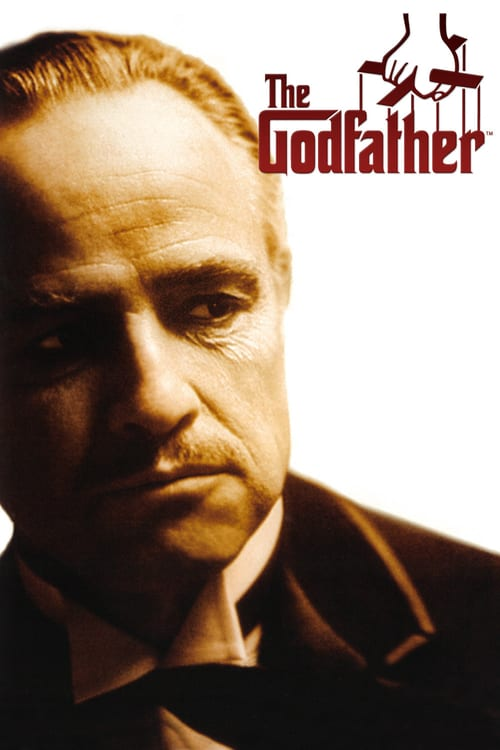

In [25]:
# найти топ-5 похожих фильмов к Крестному отцу 1
display_similar(858, num=5)

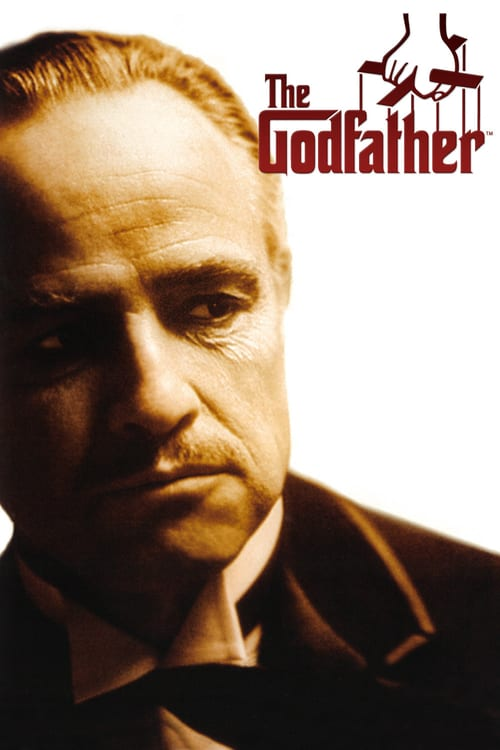

In [26]:
# добавим фильтр "без других Крестных отцов"
display_similar(858, num=5, q="title:(NOT godfather)")

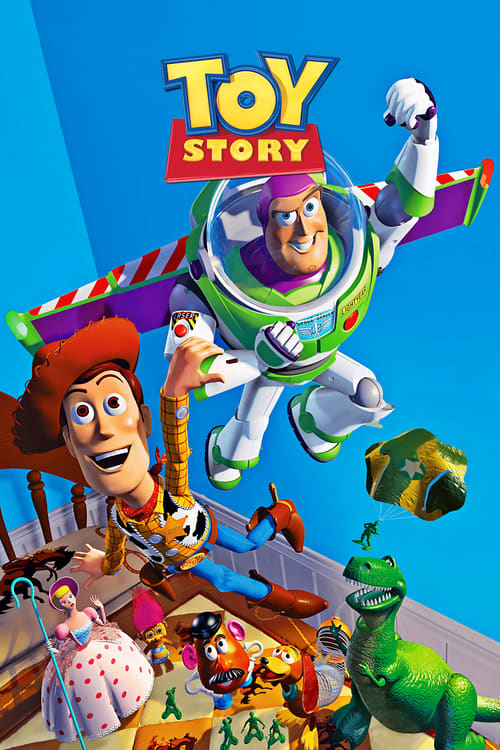

In [27]:
# фильтр по жанрам
display_similar(1, num=5, q="genres:children")

In [28]:
# поиск похожих фильмов, как смотрел какой-то пользователь
display_user_recs(72, num=5, num_last=5)

In [29]:
# + фильтр по дате (не старше, чем)
display_user_recs(72, num=5, num_last=5, q="release_date:[2017 TO *]")